In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Data Mining"

/content/drive/My Drive/Data Mining


In [60]:
import pandas as pd
import urllib.request
import numpy as np
import torch
import torchvision.transforms as T
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch import nn
from torch import optim
from PIL import Image
from sklearn.neighbors import NearestNeighbors

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
data = pd.read_csv('Data/processedData.csv', sep='|')
data.head(5)

,itemID,title,titleFound,author_raw,author_api,language,collection,isbn,publisher_raw,publisher_api,publishedDate,description,main topic,subtopics,thumbnail,maturityRating,pageCount,isEbook
0,24968,'Que prefieres? libro de juegos para niños: Pr...,¿Que Prefieres? Libro de Juegos para niños: Pr...,Jake Jokester,Jake Jake Jokester,un,1.0,9.781655e+12,LIGHTNING SOURCE INC,NaN,2020-01-02,¡Horas de diversión y unión para toda la famil...,YBG,,NaN,NOT_MATURE,125.0,False
1,69507,'el Canguro Tiene Mamá?: Does a Kangaroo Have ...,"Does a Kangaroo Have a Mother, Too? (Spanish e...",Eric Carle,Eric Carle,un,1.0,9.780060e+12,RAYO,Rayo,2002-03-26,¿Los animales tienen mama? ¡Por supuesto que s...,YFP,YFN,http://books.google.com/books/content?id=PozlG...,NOT_MATURE,32.0,False
2,39693,'n Gotiese Kers Engel (Afrikaanse uitgawe),‘n Gotiese Kers Engel (Afrikaanse Taal - Afrik...,Anna Erishkigal,Anna Erishkigal,un,1.0,9.781943e+12,Seraphim Press,Seraphim Press,2016-12-22,Wenner van die “eFestival of Words Best of the...,FM,,http://books.google.com/books/content?id=VWLGD...,NOT_MATURE,NaN,True
3,35427,'qué Día Es Hoy?/What Day Is It?,Qué día es hoy?,Alex Moran,Alex Moran,un,1.0,9.780152e+12,HARCOURT BRACE & CO,Houghton Mifflin Harcourt,2008,Todos los amigos de Gil se olvidaron de su cum...,YXHB,YF,http://books.google.com/books/content?id=e48-h...,NOT_MATURE,28.0,False
4,18462,(Commander Kellie and the Superkids' Adventure...,Commander Kellie and the Superkids Solve-It-Yo...,Christopher P. N. Maselli,Christopher P. N. Maselli,en,1.0,9.781576e+12,KENNETH COPELAND PUBN,NaN,2001,The Superkids have a whole slew of mysteries f...,YFK,,http://books.google.com/books/content?id=SdOVW...,NOT_MATURE,106.0,False


In [ ]:
for i in range(len(data)):
    thumbnail = data['thumbnail'][i]
    if pd.isnull(thumbnail):
      continue
    else:
      itemId = str(data['itemID'][i])
      urllib.request.urlretrieve(thumbnail, f"Thumbnails/{itemId}.jpg")
    if i % 1000 == 0:
      print(round((i/len(data)*100), 2))

3.34
5.0
6.67
8.34
11.67
13.34
15.01
20.01
21.68
30.02
31.69
33.36
35.02
36.69
40.03
41.7
45.03
46.7
50.04
51.7
56.71
58.37
60.04
61.71
63.38
65.05
66.71
68.38
70.05
71.72
73.38
76.72
78.39
80.06
81.72
83.39
86.73
88.4
90.06
91.73
93.4
95.07
98.4


In [ ]:
class FolderDataset(Dataset):
    """
    Creates a PyTorch dataset from folder, returning two tensor images.
    Args: 
    main_dir : directory where images are stored.
    transform (optional) : torchvision transforms to be applied while making dataset
    """

    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [ ]:
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))


    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        return x

In [ ]:
class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()

        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)

        return x

In [ ]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    train_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    optimizer: PyTorch optimizer.
    device: "cuda" or "cpu"
    Returns: Train Loss
    """
    #  Set networks to train mode.
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        if batch_idx % 50 == 0 and not batch_idx == 0:
          print(f'Batch: {batch_idx} of {len(train_loader)}')
        # Move images to device
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Zero grad the optimizer
        optimizer.zero_grad()
        # Feed the train images to encoder
        enc_output = encoder(train_img)
        # The output of encoder is input to decoder !
        dec_output = decoder(enc_output)
        
        # Decoder output is reconstructed image
        # Compute loss with it and orginal image which is target image.
        loss = loss_fn(dec_output, target_img)
        # Backpropogate
        loss.backward()
        # Apply the optimizer to network by calling step.
        optimizer.step()
    # Return the loss
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    val_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    device: "cuda" or "cpu"
    Returns: Validation Loss
    """
    
    # Set to eval mode.
    encoder.eval()
    decoder.eval()
    
    # We don't need to compute gradients while validating.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            # Move to device
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # Again as train. Feed encoder the train image.
            enc_output = encoder(train_img)
            # Decoder takes encoder output and reconstructs the image.
            dec_output = decoder(enc_output)

            # Validation loss for encoder and decoder.
            loss = loss_fn(dec_output, target_img)
    # Return the loss
    return loss.item()

In [ ]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimesntions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            # We can compute this on GPU. be faster
            train_img = train_img.to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu()
            # Keep adding these outputs to embeddings.
            embedding = torch.cat((embedding, enc_output), 0)
    
    # Return the embeddings
    return embedding

In [ ]:
# Simplified Training Script
max_loss = 0

transforms = T.Compose([T.Resize([128, 128]), T.ToTensor()]) # Normalize the pixels and convert to tensor.

full_dataset = FolderDataset("Thumbnails/", transforms) # Create folder dataset.

train_size = round(0.75 * len(full_dataset))
val_size = round(0.25 * len(full_dataset))

# Split data to train and test
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size]) 

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
 
# Create the validation dataloader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Create the full dataloader
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

loss_fn = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = ConvEncoder() # Our encoder model
decoder = ConvDecoder() # Our decoder model

# Shift models to GPU
encoder.to(device)
decoder.to(device)

# Both the enocder and decoder parameters
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-3) # Adam Optimizer

# Time to Train !!!
EPOCHS = 25
# Usual Training Loop
for epoch in range(EPOCHS):
        print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
        print('-' * 10)
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
        
        print(f"Epochs = {epoch+1}, Training Loss : {train_loss}")
        
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        
        print(f"Epochs = {epoch+1}, Validation Loss : {val_loss}")

        # Simple Best Model saving
        if val_loss < max_loss:
            print("Validation Loss decreased, saving new best model")
            torch.save(encoder.state_dict(), "encoder_model.pt")
            torch.save(decoder.state_dict(), "decoder_model.pt")
            max_loss = val_loss
        else:
            continue

Epoch: 1/25
----------
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4])
torch.Size([32, 256, 4, 4

KeyboardInterrupt: ignored

In [ ]:
# Save the feature representations.
EMBEDDING_SHAPE = (1, 256, 4, 4) # This we know from our encoder

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_loader, EMBEDDING_SHAPE, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

In [105]:
def compute_similar_images(image, num_images, embedding, device):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    
    image_tensor = T.ToTensor()(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()[0]
    return indices_list

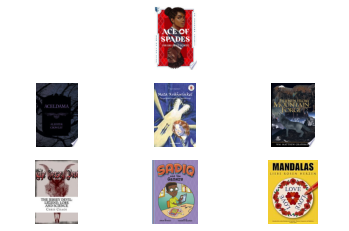

In [106]:
dir = 'Thumbnails/'
f, axarr = plt.subplots(3,3)
all_imgs = os.listdir(dir)
image = f'{dir}1004.jpg'
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axarr[0, 1].imshow(image)
image = cv2.resize(image, (128, 128))
embedding = np.load('data_embedding.npy')
image_indices = compute_similar_images(image, 6, embedding, device)
row = 1
column = 0
for index in image_indices:
  image_neighbour = f'{dir}{all_imgs[index]}'
  image_neighbour = cv2.imread(image_neighbour)
  image_neighbour = cv2.cvtColor(image_neighbour, cv2.COLOR_BGR2RGB)
  axarr[row, column].imshow(image_neighbour)
  column +=1
  if column == 3:
    column = 0
    row += 1
np.vectorize(lambda axarr:axarr.axis('off'))(axarr)
plt.show()